# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from common_utils import EmbeddingMatrix

## Question 3a

Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.

### Approach

We will use the same model as in part 2 notebook, but now we will also back propagate
the loss into the word embeddings itself. This will mean that as the model learns,
the word embeddings would also update, causing the encoding of the words to change.

We keep all other variables constant such as not handling the OOV words and using
the same hyperparameters as in part 2 notebook.

In [2]:
from common_utils import CustomDatasetPreparer


dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=32, # optimal batch size for the model in part 2
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders(ignore_unknown=True)

In [3]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x,_,lenghts, sample_y = next(dataiter)

# print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)
print()
print('Sample label size: ', lenghts.size()) # batch_size
print('Sample label: \n', lenghts)

Sample input: 
 tensor([[  232, 14503,  8453,  ..., 16163, 16163, 16163],
        [14364,    21, 14002,  ..., 16163, 16163, 16163],
        [14339,   366,   906,  ..., 16163, 16163, 16163],
        ...,
        [ 7202,  7677, 10082,  ..., 16163, 16163, 16163],
        [ 5343,  8317, 14339,  ...,  6739, 15976,    30],
        [ 4925,  7053, 14339,  ..., 14819,    30, 16163]])

Sample label size:  torch.Size([32])
Sample label: 
 tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1])

Sample label size:  torch.Size([32])
Sample label: 
 tensor([17, 23, 18,  4,  8, 36, 35,  6, 24, 26, 27, 14, 27, 23, 32, 20, 14, 10,
        35, 19, 15, 41, 23, 32, 23, 23,  8, 33,  8, 30, 41, 40])


In [4]:
class RNN(nn.Module):
    def __init__(
        self,
        hidden_dim,
        embedding_dim,
        word_embeddings: torch.tensor,
        pad_idx: int,
        num_layers=1,
        output_size=1,
        dropout_rate=0.3,
    ):
        super(RNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(
            word_embeddings, freeze=False, padding_idx=pad_idx
        )
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        self.fc = nn.Linear(hidden_dim, output_size)
        self.drop_out = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        h0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim, dtype=torch.float
        ).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        res, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        res = self.drop_out(res)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res


class RNNBatch(nn.Module):
    """
    RNN model with batch handling
    """
    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        num_layers=1,
        output_size=1,
        dropout_rate=0,
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding.from_pretrained(
            word_embeddings, freeze=False, padding_idx=pad_idx
        )
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(
            x.device
        )

        if self.dropout_rate > 0:
            embedded = self.dropout(self.embedding(x)).float()
        else:
            embedded = self.embedding(x).float()

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
        )
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )

        if self.dropout_rate > 0:
            output = self.dropout(output)

        output, _ = torch.max(output, 1)

        out = self.fc(
            output
        )  # Use the last output of the RNN for classification

        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        # print("Sig_out shape: ", sig_out.shape)
        return sig_out


from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE

# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


basic_RNN = RNN(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.3,
    pad_idx=word_embeddings.pad_idx,
    num_layers=2,
)

The index of <PAD> is:  16163


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = basic_RNN
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [6]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label).item()

# training
def train_loop(train_loader, model, loss_fn, optimizer, scheduler, max_norm = 5, device='cpu'):
    train_loss = []
    train_acc = 0.0
    model.train()
    for X, extra_features, lengths, Y in train_loader:
        X, Y = X.to(device), Y.to(device)   

        optimizer.zero_grad()
        output = model(X, lengths)
        
        # calculate the loss and perform backprop
        loss = loss_fn(output.squeeze(), Y.float())
        train_loss.append(loss.item())
        loss.backward()
        
        # calculating accuracy
        accuracy = acc(output,Y)
        train_acc += accuracy
        
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        
    scheduler.step()
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = train_acc/len(train_loader.dataset)

    return epoch_train_loss, epoch_train_acc

def test_loop(test_loader, model, loss_fn, optimizer, device='cpu'):
    test_loss = []
    test_acc = 0.0
    model.eval()
    with torch.no_grad():
        for X,extra_features, lengths, Y in test_loader:
            X, Y = X.to(device), Y.to(device)   

            optimizer.zero_grad()
            output = model(X, lengths)
            
            # calculate the loss and perform backprop
            loss = loss_fn(output.squeeze(), Y.float())

            test_loss.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,Y)
            test_acc += accuracy

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = test_acc/len(test_loader.dataset)

    return epoch_test_loss, epoch_test_acc

def train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience):
    best_val_loss = np.inf
    best_acc = 0
    train_loss_, train_acc_, val_loss_, val_acc_ = [], [], [], []
    from tqdm import tqdm
    # start training
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, scheduler)
        val_loss, val_acc = test_loop(val_loader, model, loss_fn, optimizer)

        train_loss_.append(train_loss), train_acc_.append(train_acc)
        val_loss_.append(val_loss), val_acc_.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= es_patience:
                print(f'early stopping after {epoch+1} epochs')
                print(f'best val loss: {best_val_loss}')
                print(f'best accuracy on val set: {best_acc}')
                break

        if epoch % 10 == 0:
            print(f"epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, val_loss {val_loss:>7f}, val_acc {val_acc:>4f}")

    return train_loss_, train_acc_, val_loss_, val_acc_

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

  1%|          | 1/100 [00:02<04:03,  2.46s/it]

epoch 1, train_loss 0.676044 train_acc 0.574912, val_loss 0.617047, val_acc 0.682927


 11%|█         | 11/100 [00:27<03:52,  2.62s/it]

epoch 11, train_loss 0.313346 train_acc 0.872450, val_loss 0.528531, val_acc 0.757036


 21%|██        | 21/100 [00:53<03:23,  2.57s/it]

epoch 21, train_loss 0.141040 train_acc 0.955686, val_loss 0.662376, val_acc 0.772045


 22%|██▏       | 22/100 [00:58<03:26,  2.65s/it]

early stopping after 23 epochs
best val loss: 0.4851689040660858
best accuracy on val set: 0.7786116322701688


# Question 3a Answer

(a) We use the same RNN model with the same parameters and we found that by unfreezing the weights, the performance of the model went for the test set. We hypothesize this is the case as the word embeddings are
generalized and not specific to the task at hand. By updating the word embeddings, the model can learn the specific embeddings for the small dataset that was given to us.

We show our results in the following 2 cells where we obtained a much better accuracy on the validation and test set.

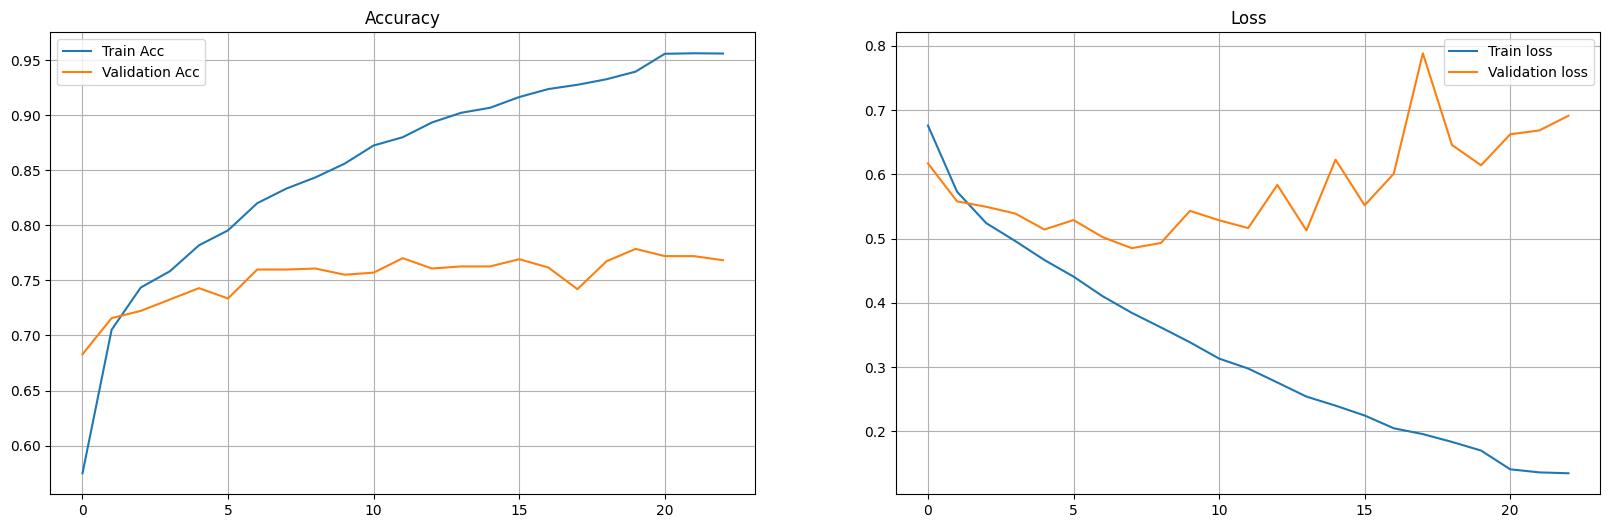

In [7]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_):
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_, label='Train Acc')
    plt.plot(val_acc_, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
        
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_, label='Train loss')
    plt.plot(val_loss_, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()

    plt.show()

plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

In [8]:
test_loss, test_acc = test_loop(test_loader, model, loss_fn,optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

test_loss 0.595542, test_acc 0.783302


# Question 3b

### Approach

As discussed in part 1, we have mentioned 2 approaches to handling of the
OOV words. We will now demonstrate the first approach, which is to replace the OOV
words with a special token. We will replace the OOV words with a special token
`<UNK>`.

In [9]:
from common_utils import EMBEDDING_DIM, UNK_TOKEN, load_glove_embeddings


w2v_model = EmbeddingMatrix.load()
extended_vocab = w2v_model.vocab

glove_dict = load_glove_embeddings()

# Collect words to be removed
missing_words = []
for word in extended_vocab:
    if word not in glove_dict:
        missing_words.append(word)

# Remove missing words from vocab
for word in missing_words:
    extended_vocab.remove(word)
        
print(f"Number of missing words: {len(missing_words)}")
print(f"The missing words are: {missing_words}")

extended_vocab.add(UNK_TOKEN)

# mapping of words to indices and vice versa
word2idx = {word: idx for idx, word in enumerate(sorted(extended_vocab))}
idx2word = {idx: word for word, idx in word2idx.items()}

print("Building embedding matrix...")
vocab_size = len(word2idx)
print(f"Vocab size: {vocab_size}")
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in word2idx.items():
    if word == UNK_TOKEN:
        continue
    embedding_matrix[idx] = glove_dict[word]

# add random vector for unknown words
embedding_matrix[word2idx[UNK_TOKEN]] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

print("Embedding matrix built successfully.")

print(f"Index of <UNK> token: {word2idx['<UNK>']}")


Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000
Number of missing words: 0
The missing words are: []
Building embedding matrix...
Vocab size: 16164
Embedding matrix built successfully.
Index of <UNK> token: 226


To aid us in the downstream task for the rest of the analysis that we will be
doing, we will update the EmbeddingMatrix class that was earlier defined to
also handle the case of unknown words.

We define the class using an API interface which can be easily called.

In [10]:
import json
from common_utils import EMBEDDING_MATRIX_PATH, WORD2IDX_PATH, IDX2WORD_PATH

class EmbeddingMatrix:
    def __init__(self, unk_token=UNK_TOKEN, handle_unknown=True) -> None:
        self.d = 0
        self.v = 0
        self.pad_idx: int
        self.unk_idx: int
        self.embedding_matrix: np.ndarray
        self.word2idx: dict
        self.idx2word: dict
        self.unk_token = unk_token
        self.handle_unknown = handle_unknown

    @classmethod
    def load(cls) -> "EmbeddingMatrix":
        # load vectors from file
        embedding_matrix: np.ndarray = np.load(EMBEDDING_MATRIX_PATH)
        # set attributes
        em = cls()
        em.embedding_matrix = embedding_matrix

        with open(WORD2IDX_PATH, "r", encoding="utf-8") as f:
            word2idx: dict = json.load(f)
            em.word2idx = word2idx
        with open(IDX2WORD_PATH, "r", encoding="utf-8") as f:
            idx2word: dict = json.load(f)
            em.idx2word = idx2word
            
        em.v, em.d = embedding_matrix.shape
        return em

    def save(self) -> None:
        np.save(EMBEDDING_MATRIX_PATH, self.embedding_matrix)
        
        with open(WORD2IDX_PATH, "w", encoding="utf-8") as f:
            json.dump(self.word2idx, f, ensure_ascii=False, indent=4)
            
        with open(IDX2WORD_PATH, "w", encoding="utf-8") as f:
            json.dump(self.idx2word, f, ensure_ascii=False, indent=4)

    @property
    def to_tensor(self) -> torch.Tensor:
        return torch.tensor(self.embedding_matrix, dtype=torch.float)

    def add_padding(self) -> None:
        if "<PAD>" in self.word2idx:
            return
        padding = np.zeros((1, self.d), dtype="float32")
        self.embedding_matrix = np.vstack((self.embedding_matrix, padding))

        self.v += 1
        self.pad_idx = self.v - 1
        self.word2idx["<PAD>"] = self.pad_idx

    def add_unk_token(self) -> None:
        if self.unk_token in self.word2idx:
            return
        unk_vector = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))
        self.embedding_matrix = np.vstack((self.embedding_matrix, unk_vector))

        self.v += 1
        self.unk_idx = self.v - 1
        self.word2idx[self.unk_token] = self.unk_idx

    @property
    def dimension(self) -> int:
        """Dimension of the embedding matrix

        :return: The dimension of the embedding matrix
        :rtype: int
        """
        return self.d

    @property
    def vocab_size(self) -> int:
        """Vocabulary size of the embedding matrix

        :return: The vocabulary size of the embedding matrix
        :rtype: int
        """
        return self.v

    @property
    def vocab(self) -> set[str]:
        """Vocabulary of the embedding matrix

        Set of words in the embedding matrix

        :return: The vocabulary of the embedding matrix
        :rtype: set[str]
        """
        return set(self.word2idx.keys())

    def __getitem__(self, word: str) -> np.ndarray:
        return self.embedding_matrix[self.word2idx[word]]

    def get_idx(self, word: str) -> int:
        # if word not in vocab, return None
        if self.handle_unknown:
            return self.word2idx.get(word, self.unk_idx)

        return self.word2idx.get(word, None)
    
    def is_in_vocab(self, word: str) -> bool:
        return word in self.word2idx

    def is_in_index(self, idx: int) -> bool:
        return idx in self.idx2word

## Fast Text Embeddings
For the second approach, we will use the FastText embeddings, which are trained on
subword information. This will help in encoding the OOV words as well.

In [11]:
# Implementation of FastText for word embedding
import gensim
from gensim.models import FastText
from common_utils import EMBEDDING_DIM
# Create a FastText model with the same dimensions as the Word2Vec model
fasttext_model = FastText(
    vector_size=EMBEDDING_DIM,
    window=5, # context window size 
    min_count=1, # threshold for word frequency
    workers=4
)

In [12]:
from datasets import load_dataset, Dataset
from common_utils import EmbeddingMatrix, tokenize
import nltk
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']

corpus = []
for example in train_dataset:
    tokens = nltk.word_tokenize(example['text'])
    corpus.append(tokens)
    
# add padding and unknown token
corpus = [["<PAD>", "<UNK>"]] + corpus
print("The corpus has {} documents.".format(len(corpus)))

The corpus has 8531 documents.


In [13]:
fasttext_model.build_vocab(corpus_iterable=corpus)
# fasttext_model.build_vocab(corpus_iterable=corpus, update=True)

print("Length of vocabulary:", len(fasttext_model.wv.key_to_index))


fasttext_model.train(
    corpus_iterable=corpus, epochs=fasttext_model.epochs,
    total_examples=fasttext_model.corpus_count, total_words=fasttext_model.corpus_total_words,
)

Length of vocabulary: 18032


(657394, 919850)

In [14]:
"<UNK>" in fasttext_model.wv.key_to_index

True

In [15]:
fasttext_vocab = set(fasttext_model.wv.key_to_index.keys())
w2v_model = EmbeddingMatrix.load()

In [16]:
w2v_model.vocab - fasttext_vocab

set()

In [17]:
fasttext_vocab - w2v_model.vocab

{'big-fisted',
 'live-style',
 'one-joke',
 'stomach-turning',
 "'german-expressionist",
 'period-perfect',
 'slice-of-depression',
 'spy-movie',
 'girl-meets-girl',
 'nolden',
 'timewaster',
 'sermonize',
 'ho-hum',
 '\x96',
 'edge-of-your-seat',
 "'in",
 'pro-fat',
 'singer-turned',
 'provocatuers',
 'thrill-kill',
 'decasia',
 'lynch-like',
 'super-simple',
 'roisterous',
 'docu-makers',
 'capturou',
 'unentertaining',
 'played-out',
 "'too",
 "'korean",
 "aren't-kids-cute",
 'conmovedora',
 'navel-gazing',
 'miscasts',
 'light-footed',
 "'inspirational",
 'rambo-',
 'sober-minded',
 'out-shock',
 'accomodates',
 'makmalbaf',
 'critic-proof',
 'sock-you-in-the-eye',
 'you-are-there',
 'girl-on-girl',
 'direto',
 'cliché-laden',
 'recoing',
 "'bowling",
 'brit-com',
 'field-sized',
 'sinais',
 'logra',
 'wild-and-woolly',
 'young-guns',
 'russos',
 'super-cool',
 '-west',
 'nonethnic',
 'kasem-furnished',
 'a-bornin',
 'outgag',
 'sumamente',
 '-hollywood',
 'stiff-upper-lip',
 'ultr

In [18]:
print("The FastText model has {} words.".format(len(fasttext_model.wv.key_to_index)))
print("The Word2Vec model has {} words.".format(len(w2v_model.vocab)))
print("The FastText model has {} words that are not in the Word2Vec model.".format(len(fasttext_vocab - w2v_model.vocab)))
print("The Word2Vec model has {} words that are not in the FastText model.".format(len(w2v_model.vocab - fasttext_vocab)))

The FastText model has 18032 words.
The Word2Vec model has 16163 words.
The FastText model has 1869 words that are not in the Word2Vec model.
The Word2Vec model has 0 words that are not in the FastText model.


# Question 3b Answer

(b) The following code shows the performance of the model with OOV handling
where the model would have the learn the embeddings for the unknown words
that it might occur and subsequently how to classify an `<UNK>` token that.

## Testing the OOV Handling

With the OOV handling defined, we now define the handing of the dataloader
with the new embedding containing the `<UNK>` token. We will also now
define an RNN model with the updated embedding matrix and run it on the
data loader to test the performance gain.

In [19]:
from common_utils import CustomDatasetPreparer, BATCH_SIZE

dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE,
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [20]:
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)
print("The index of <UNK> is: ", word_embeddings.unk_idx)


basic_RNN = RNN(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.3,
    pad_idx=word_embeddings.pad_idx,
    num_layers=2,
)


The index of <PAD> is:  16163
The index of <UNK> is:  16164


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = basic_RNN
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)


  1%|          | 1/100 [00:01<03:04,  1.87s/it]

epoch 1, train_loss 0.683036 train_acc 0.562720, val_loss 0.661714, val_acc 0.622889


 11%|█         | 11/100 [00:20<02:44,  1.85s/it]

epoch 11, train_loss 0.360422 train_acc 0.846190, val_loss 0.496142, val_acc 0.762664


 21%|██        | 21/100 [00:40<02:35,  1.97s/it]

epoch 21, train_loss 0.181790 train_acc 0.938453, val_loss 0.604907, val_acc 0.752345


 25%|██▌       | 25/100 [00:50<02:30,  2.00s/it]

early stopping after 26 epochs
best val loss: 0.49614170600067486
best accuracy on val set: 0.7626641651031895


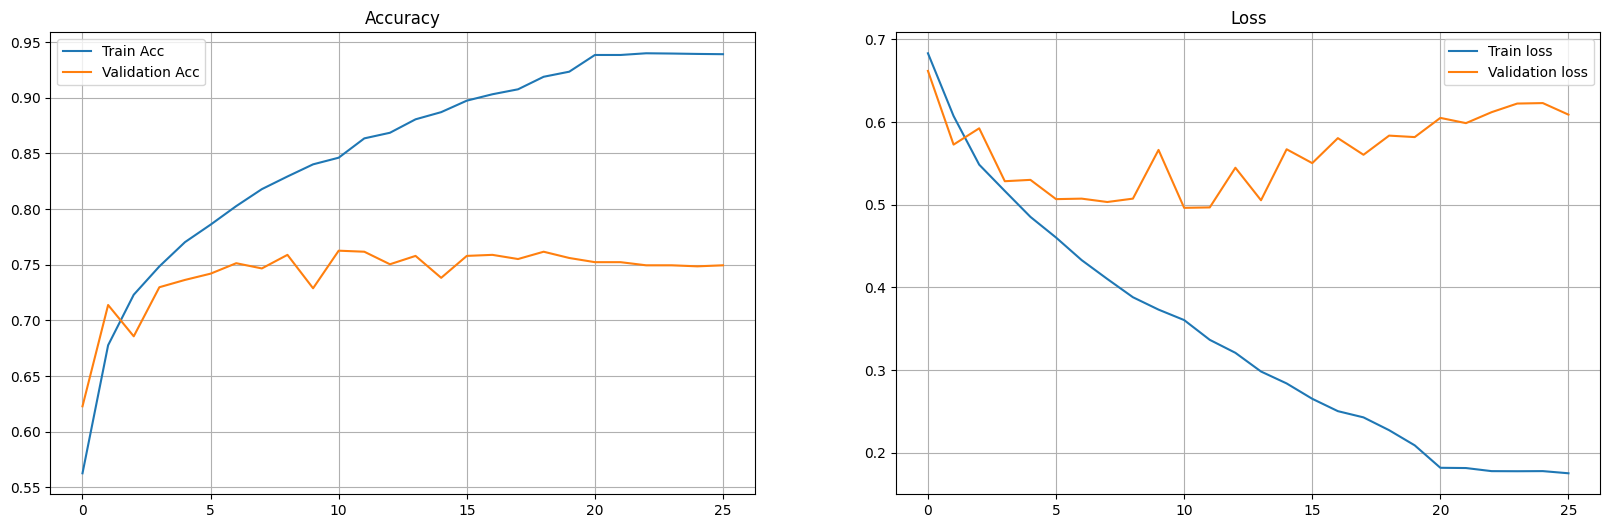

test_loss 0.584697, test_acc 0.777674


In [22]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Testing the FastText model

Fast text model includes the handling through <UNK> and the subword information.

In [23]:
from common_utils import CustomDatasetPreparer, BATCH_SIZE

manual_embedding = EmbeddingMatrix()
idx2word = {str(idx):word for idx, word in enumerate(fasttext_model.wv.index_to_key)}
manual_embedding.load_manual(fasttext_model.wv.key_to_index, idx2word, fasttext_model.wv.vectors)
word_embeddings = manual_embedding

dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE,
    manual_embeddings=manual_embedding,
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [ ]:
print("The index of <PAD> is: ", word_embeddings.pad_idx)
print("The index of <UNK> is: ", word_embeddings.unk_idx)


basic_RNN = RNN(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.3,
    pad_idx=word_embeddings.pad_idx,
    num_layers=2,
)


The index of <PAD> is:  18031
The index of <UNK> is:  9017


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = basic_RNN
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)


  1%|          | 1/100 [00:02<03:37,  2.20s/it]

epoch 1, train_loss 0.694331 train_acc 0.505275, val_loss 0.692126, val_acc 0.500938


 11%|█         | 11/100 [00:21<02:59,  2.02s/it]

epoch 11, train_loss 0.499880 train_acc 0.769988, val_loss 0.640778, val_acc 0.680113


 21%|██        | 21/100 [00:41<02:29,  1.90s/it]

epoch 21, train_loss 0.086720 train_acc 0.976084, val_loss 0.706876, val_acc 0.755159


 28%|██▊       | 28/100 [00:56<02:24,  2.01s/it]

early stopping after 29 epochs
best val loss: 0.5461109524423425
best accuracy on val set: 0.7626641651031895


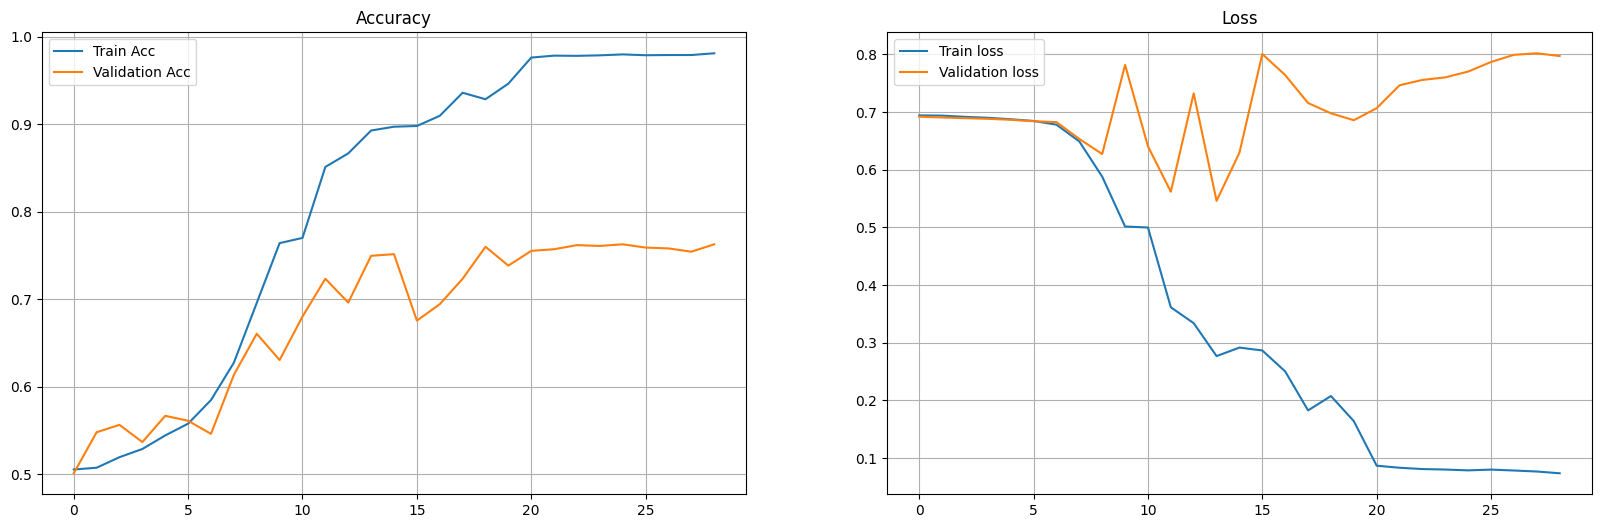

test_loss 0.689433, test_acc 0.780488


In [26]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")